In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import emcee

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

In [2]:
posterior=pd.read_csv("MCMC_samples_scenario_10_40_full_posterior.dat",delim_whitespace=True,header=None)

In [3]:
y_val = torch.tensor([134,100,133,0.6])

In [4]:
posterior.shape

(54000, 7)

     CV_ventricles  CV_atria  a_atria   EDP_lv   EDP_rv     Rsys    Rpulm
0         0.583426  0.559737  2.63999  3.00130  4.86389  2.62436  1.74940
1         0.513584  0.679305  3.15695  5.65473  6.89338  2.07232  3.77998
2         0.528843  0.596498  4.85812  5.02497  2.16558  1.34170  2.09279
3         0.576382  0.320044  2.30249  3.45923  3.79267  1.44626  3.62270
4         0.706760  0.986539  1.47919  2.71888  3.53382  3.55907  3.37904
..             ...       ...      ...      ...      ...      ...      ...
995       0.492465  0.433849  3.11757  1.13969  5.68550  2.69079  1.14159
996       0.693082  0.775705  3.06761  3.16270  5.87700  2.03175  3.11116
997       0.383862  0.422026  3.75881  2.76191  7.32266  2.90629  2.73541
998       0.391658  0.580093  3.14632  7.38027  6.52224  3.83890  1.65956
999       0.488805  0.328415  4.39081  5.60215  1.67397  1.75135  3.87967

[1000 rows x 7 columns]
     LVedv  LVedp   LVesv  LVpMax  LVdpdtMax  LVdpdtMin   RVedv  RVedp  \
0   167.78   

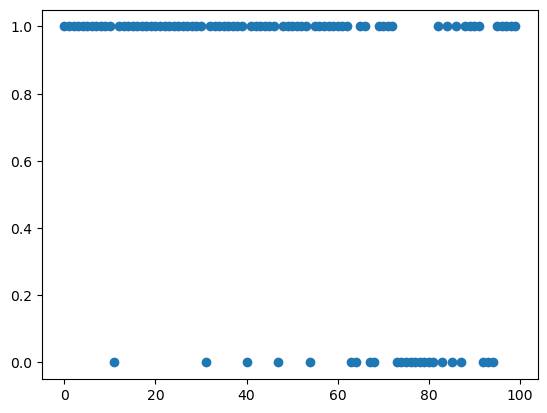

In [5]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_10/xlabels.txt',delim_whitespace=True,header=None)


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_10/X.txt',index_col=None,delim_whitespace=True,header=None)
X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

mask = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_10/output_mask_beat_5.txt',index_col=None,delim_whitespace=True,header=None)

np.sum(mask)

plt.plot(mask,'o')

y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_10/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_10/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)



input_masked = X_all.copy().iloc[0:mask.shape[0]]
input_complete=input_masked.copy().iloc[np.array(mask==1),]
input_failed=input_masked.copy().iloc[np.array(mask==0),]

In [6]:
input_masked = X_all.copy().iloc[0:mask.shape[0]]

input_masked=input_masked.iloc[np.array(mask==1),]

nDim = input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

x_all = torch.tensor(input_masked.values)

y_calibration = y_all.loc[:,['A_TAT','V_TAT','LVpMax']]

y_calibration2 = pd.DataFrame({'LV_EF':(y_all.loc[:,'LVedv']-y_all.loc[:,'LVesv'])/y_all.loc[:,'LVedv']})

y_calibration=torch.tensor(y_calibration.join(y_calibration2).values)





y_max=y_calibration.max(axis=0)

y_max

y_test = y_calibration[y_max[1][3],:]
x_test = x_all[y_max[1][3],:]

y_train = y_calibration[~torch.all(y_calibration == y_test, dim=1)]
x_train = x_all[~torch.all(x_all == x_test, dim=1)]


emulator=GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)


[0.386498, 0.799253]
[0.305504, 1.02567]
[1.47919, 4.96054]
[1.05607, 7.27469]
[1.06364, 7.4999]
[1.02992, 3.98405]
[1.03672, 3.85692]
0
1
2
3


In [7]:
posterior=torch.tensor(posterior.values)

In [8]:
ll=torch.sum(emulator.ensemble_log_likelihood_obs_error(posterior[45000:45100],y_test[None],[0.1,0.1,0.1,0.001]),axis=0)

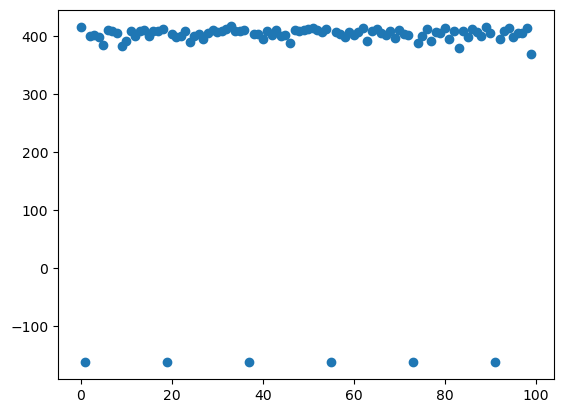

In [9]:
plt.plot(ll.detach().numpy().T,'o')

In [10]:
posterior[1:100].shape

torch.Size([99, 7])

In [11]:
y_test

tensor([144.1990,  89.5618,  73.9400,   0.4480], dtype=torch.float64)

In [12]:
(emulator.predict(posterior[45000:45100])-y_test)**2

tensor([[8.0570e-02, 1.5792e-01, 7.4134e-02, 8.5683e-04],
        [1.9333e+04, 2.8898e+02, 1.8267e+01, 5.4548e-02],
        [5.6541e-02, 8.2740e-05, 4.5419e-01, 2.0914e-03],
        [2.8150e-01, 4.2924e-02, 3.2275e-01, 9.0637e-04],
        [2.4589e-01, 1.5865e-02, 5.7827e-02, 2.6966e-03],
        [7.9119e-03, 3.4471e-02, 4.1009e-01, 1.8257e-03],
        [4.5145e-05, 4.4726e-02, 7.3638e-06, 5.5488e-04],
        [1.9164e-02, 1.3193e-01, 7.9028e-04, 3.9411e-03],
        [2.1381e-03, 9.6515e-03, 6.2213e-01, 2.3766e-03],
        [4.4254e-04, 5.3778e-01, 7.3541e-02, 5.5252e-04],
        [5.8475e-02, 2.7842e-02, 1.3779e-03, 7.0388e-04],
        [2.4370e-02, 3.5912e-03, 2.1322e-01, 1.1896e-03],
        [1.7303e-02, 1.1471e-03, 4.0163e-02, 2.1267e-04],
        [1.0181e-02, 2.6864e-01, 1.5280e-01, 1.4489e-04],
        [1.0120e-02, 6.6751e-01, 6.6429e-02, 8.4735e-04],
        [2.3264e-01, 5.0687e-02, 4.6937e-04, 1.5967e-03],
        [4.0068e-02, 1.1974e-04, 3.1621e-01, 6.3264e-04],
        [4.854

In [13]:
ll=(emulator.ensemble_log_likelihood_obs_error(posterior[45000:45100],y_test[None],[0.1,0.1,0.1,0.1]))

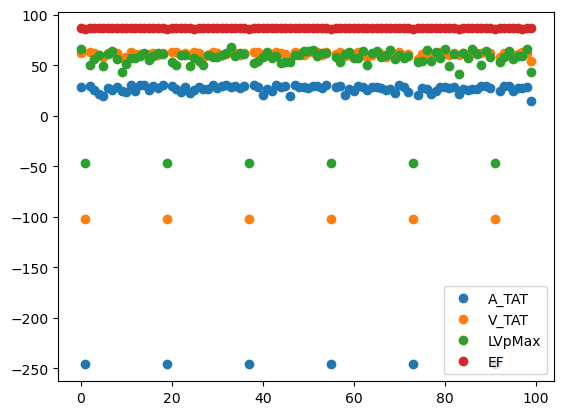

In [14]:
plt.plot(ll.detach().numpy().T,'o')
plt.legend(['A_TAT','V_TAT','LVpMax','EF'])

In [15]:
ll.T

tensor([[  28.9211,   62.5062,   66.1173,   86.3420],
        [-246.1133, -101.9733,  -46.8965,   86.0638],
        [  29.2441,   63.1491,   50.5313,   86.3354],
        [  24.9830,   62.3826,   56.1497,   86.3417],
        [  21.0694,   59.6233,   60.2080,   86.3326],
        [  19.7795,   58.1524,   48.9385,   86.3364],
        [  27.7380,   62.3810,   61.3484,   86.3433],
        [  25.0680,   61.9457,   64.4095,   86.3265],
        [  28.2041,   62.3872,   56.4499,   86.3341],
        [  24.5642,   56.9750,   43.1132,   86.3429],
        [  23.9190,   58.4984,   50.9026,   86.3423],
        [  30.6095,   62.6182,   57.5524,   86.3400],
        [  24.0615,   60.9660,   57.1519,   86.3448],
        [  30.0424,   61.2571,   58.8300,   86.3454],
        [  30.0612,   60.6722,   61.6212,   86.3419],
        [  25.4071,   60.8011,   55.2923,   86.3381],
        [  29.3034,   62.2059,   58.7904,   86.3428],
        [  27.0020,   60.0390,   62.4305,   86.3451],
        [  29.9386,   62.538

In [16]:

    
inputNorm,outputNorm = emulator.normalise_test_data(posterior,y_test)
inputNorm=inputNorm.float()
outputNorm=outputNorm.float()
sigma = 0.1
i=3
emulator.models[i].eval()
emulator.likelihoods[i].eval()
posterior=posterior.float()
m = emulator.likelihoods[i](emulator.models[i](inputNorm[45000:45010])).mean
k = emulator.likelihoods[i](emulator.models[i](inputNorm[45000:45010])).covariance_matrix.diag()

likelihood_manual=-0.5*((y_test[i]-(emulator.training_output_STD[i]*m+emulator.training_output_mean[i]))**2)/(emulator.training_output_STD[i]*k+sigma) -0.5*nDim*torch.log(emulator.training_output_STD[i]*k+sigma)

In [17]:
torch.sum(inputNorm)

tensor(-25860.0938)

In [18]:
outputNorm

tensor([ 0.0628, -0.6205, -1.0796,  1.9936])

In [19]:
likelihood_manual

tensor([8.0537, 7.7712, 8.0469, 8.0533, 8.0443, 8.0477, 8.0550, 8.0382, 8.0457,
        8.0544], grad_fn=<SubBackward0>)

In [20]:
nMod = emulator.training_output_normalised.shape[1]
nDim = emulator.training_output_normalised.shape[0]
#nP = posterior[45000:45010].shape[0]
#likelihood_eval = torch.zeros((nMod,nP))

#inputNorm,outputNorm = emulator.normalise_test_data(posterior,y_test)
#inputNorm=inputNorm.float()
#outputNorm=outputNorm.float()
#sigma = 0.1
#posterior=posterior.float()
#for i in range(4):
#    emulator.models[i].eval()
#    emulator.likelihoods[i].eval()
#    
#    m = emulator.likelihoods[i](emulator.models[i](inputNorm[45000:45010])).mean
#    k = emulator.likelihoods[i](emulator.models[i](inputNorm[45000:45010])).covariance_matrix.diag()
#
#    likelihood_manual=-0.5*((y_test[i]-(emulator.training_output_STD[i]*m+emulator.training_output_mean[i]))**2)/(emulator.training_output_STD[i]*k+sigma) -0.5*nDim*torch.log(emulator.training_output_STD[i]*k+sigma)
#    likelihood_eval[i,:] = likelihood_manual

In [21]:
likelihood_manual

tensor([8.0537, 7.7712, 8.0469, 8.0533, 8.0443, 8.0477, 8.0550, 8.0382, 8.0457,
        8.0544], grad_fn=<SubBackward0>)

In [22]:
likelihood_eval[3]

NameError: name 'likelihood_eval' is not defined

In [ ]:
(emulator.ensemble_log_likelihood_obs_error(posterior[45000:45010],y_test[None],[0.1,0.1,0.1,0.1]))[3]

In [24]:
emulator.training_output_normalised

tensor([[ 0.2982,  0.0195,  0.2952, -0.5431],
        [-0.2614,  0.6707, -0.9839, -0.2191],
        [ 0.0821,  0.3635, -0.8750,  1.9002],
        [ 2.6367,  0.0303, -1.2738,  0.7704],
        [-1.0597, -0.7500,  1.0666, -0.9360],
        [-0.9415,  1.3520,  0.1052, -0.1515],
        [-0.5637,  0.1331, -1.5138, -0.2205],
        [-1.0853,  0.8964,  1.0458,  1.0480],
        [ 0.0054, -0.5829,  0.9951,  0.4152],
        [-0.1504,  1.5830,  1.0173, -0.0582],
        [-0.3025,  1.5241, -1.7615, -0.1849],
        [-0.2907,  2.1961, -1.6970,  1.4965],
        [-0.2371, -1.1328,  0.1967,  1.1830],
        [-0.7372, -0.5667,  0.8335, -0.5867],
        [-0.1098, -0.1969,  0.8953,  0.7179],
        [-0.0077,  0.7387, -1.2350,  1.7837],
        [-1.1469, -0.8347, -0.0821,  0.5316],
        [ 1.2460, -0.0645,  0.4714, -1.7176],
        [-0.9551,  0.2303,  1.7700, -1.2399],
        [-0.0343,  0.3187, -0.5344, -0.2763],
        [ 2.9286,  1.8705, -0.0648, -1.9023],
        [ 0.4600, -0.8735,  1.2525

In [25]:
m.shape

torch.Size([10])